In this MiniProject, we implement the multi-Controlled Unitary gate using only X, CX, U, H and Toffoli (= combo of Phase change, Hadamards and CX) gates.

 and we also reference several parts of Barenco et al, Elementary gates for quantum computation.

Contents: 
- The implementation of $C^nU$ for  $n=1,2$ controlled qubits of Figure 4.6, Nielsen-Chuang.
- Implementation of strong induction method for $N\in \mathbb{N}$ realizing $C^NU$ with another unitary $V$ such that $V^{2^N-1}=U.$ (it ran all the way to $N=7$ in reasonable time)
- Implementation using $\textit{transpile}$ method for some specific numbers of qubits.

Autors: Roberto Hernández Palomares & Lara Ismert

In [1]:
#import packages we'll need
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
from qiskit import transpile

import numpy as np

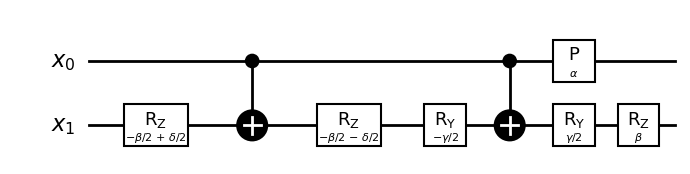

In [3]:
###########  n =1, CU
# We first implement the CU gate on n=1 QuBits for an arbitrary U \in U(2)
# Recall from N-C that U can be factored as U = exp{i\alpha}AXBXC, where A, B, C are explicit rotations such that ABC = \id_2.
# N-C Cor4.2 gives: A ≡ Rz(β)Ry(γ/2), B ≡ Ry(−γ/2)Rz(−(δ +β)/2) and C ≡ Rz((δ − β)/2)

CU_register = QuantumRegister(size=2, name="x") 
CU = QuantumCircuit(CU_register, name="CU") 

# We now construct A, B and C
## Declaring formal parameters: 
Alpha, Delta, Beta, Gamma, Theta, Phi, Lambda = Parameter(r"$\alpha$"), Parameter(r"$\delta$"), Parameter(r"$\beta$"), Parameter(r"$\gamma$"), Parameter(r"$\theta$"), Parameter(r"$\varphi$"), Parameter(r"$\lambda$")

#### Formal CU gate with symbolic parameters

    #CU.C(1) = C ≡ Rz((δ − β)/2)
CU.rz((Delta-Beta)/2, CU_register[1])
CU.cx(0, 1)
    #CU.B(1) =  B ≡ Ry(−γ/2)Rz(−(δ +β)/2)
CU.rz(-(Delta+Beta)/2, CU_register[1])
CU.ry(-(Gamma)/2, CU_register[1])
CU.cx(0, 1)
    #CU.A(1) = Rz(β)Ry(γ/2)
CU.ry(Gamma/2, CU_register[1])
CU.rz(Beta, CU_register[1])
    #Phase
CU.p(Alpha, CU_register[0])


CU.draw(output="mpl", style="bw")

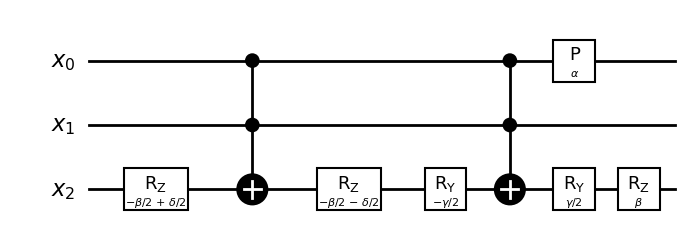

In [5]:
###########  n =2, CCU
# We write the double controlled U gate formally using the Toffoli gate. 

CCU_register = QuantumRegister(size=3, name = 'x')
CCU = QuantumCircuit(CCU_register, name="CCU")

### Formal CCU gate with formal parameter
    #CU.C(1) = C ≡ Rz((δ − β)/2)
CCU.rz((Delta-Beta)/2, CCU_register[2])
    #Toffoli
CCU.ccx(0, 1, 2)
    #CU.B(1) =  B ≡ Ry(−γ/2)Rz(−(δ +β)/2)
CCU.rz(-(Delta+Beta)/2, CCU_register[2])
CCU.ry(-(Gamma)/2, CCU_register[2])
    #Toffoli
CCU.ccx(0, 1, 2)
    #CU.A(1) = Rz(β)Ry(γ/2)
CCU.ry(Gamma/2, CCU_register[2])
CCU.rz(Beta, CCU_register[2])
    #Phase
CCU.p(Alpha, CCU_register[0])

CCU.draw(output='mpl', style='bw')

$\textbf{`Strong induction method'}:$

From the paper $\textit{Elementary gates for quantum computation}$ by Barenco et al, we picked an idea from the identity displayed on pge 18
$$
\sum_{k_1}x_{k_1} - \sum_{k_1<k_2}(x_{k_1}\oplus x_{k_1}) + \sum_{k_1<k_2<k_3}(x_{k_1}\oplus x_{k_2}\oplus x_{k_3})-\cdots +(-1)^{n-1}(x_1\oplus x_2\oplus\cdots\oplus x_n) =  2^{n-1}(x_1\cdot x_2\cdot \cdots \cdot x_n).
$$
The right hand side is (a multiple of) a gate that only opens whenever all the boolean entries equal one simultaneously; i.e. corresponds to $C^n{U}$. The identity tells us precisely how to express this opening condition on $n$ boolean variables in terms of all other combinations of $C^kV$ and $C^kV^\dagger$ depending on parity, for $k=0,1,...,m-1$ applied over all $k$ elements subsets of the variables.  Here, $V$ is another unitary satisfying $V^{2^{n-2}}=U$.

We notice this is rather inefficient, however it gets the job done. For the most, we only care about $U = X$.

To implement this expression we prepare a couple of functions in order to be able to iterate over all $m$-elements ordered increasing subsets of $1, 2, ..., N$ corresponding to the indices of the sums. 

In [210]:
def SumMod2_Tuple (K, m): #sums Mod 2 over entries of m-tuple K
    sum = 0 
    for i in range(0, m):
        sum = (sum + K[i])%2
    return sum

def Inc_K (K, m): # Verifies if given m-tuple is strictly increasing
    val = True
    for i in range(m-1):
        if K[i] >= K[i+1]:
            val = False
            return val
    return val

def m_DimArray(m):  # Creates an m-dimensional array to parameterize all values of i_1, ... i_m
    L = [1]
    for i in range(m):
        L = [L]*m
        return L

The following function ranges over al k-element increasing ordered subsets of N

In [325]:
### This function ranges over al k-element increasing ordered subsets of N
import itertools  # This helps iterating loops over complex parameter spaces

N = 3
for m in range(1,N+1):#ranging over the degree of monomials
    shape = [N]*m
    for iK in itertools.product(*[range(s) for s in shape]):
        if Inc_K(iK, m): #Inc_K verifies condition   
            iK = [iK[i] + ([1]*(len(iK)))[i] for i in range(len(iK))]
            print('iK=', iK)

iK= [1]
iK= [2]
iK= [3]
iK= [1, 2]
iK= [1, 3]
iK= [2, 3]
iK= [1, 2, 3]


We now loop over all these subsets and add a k-controllex X gate for each:

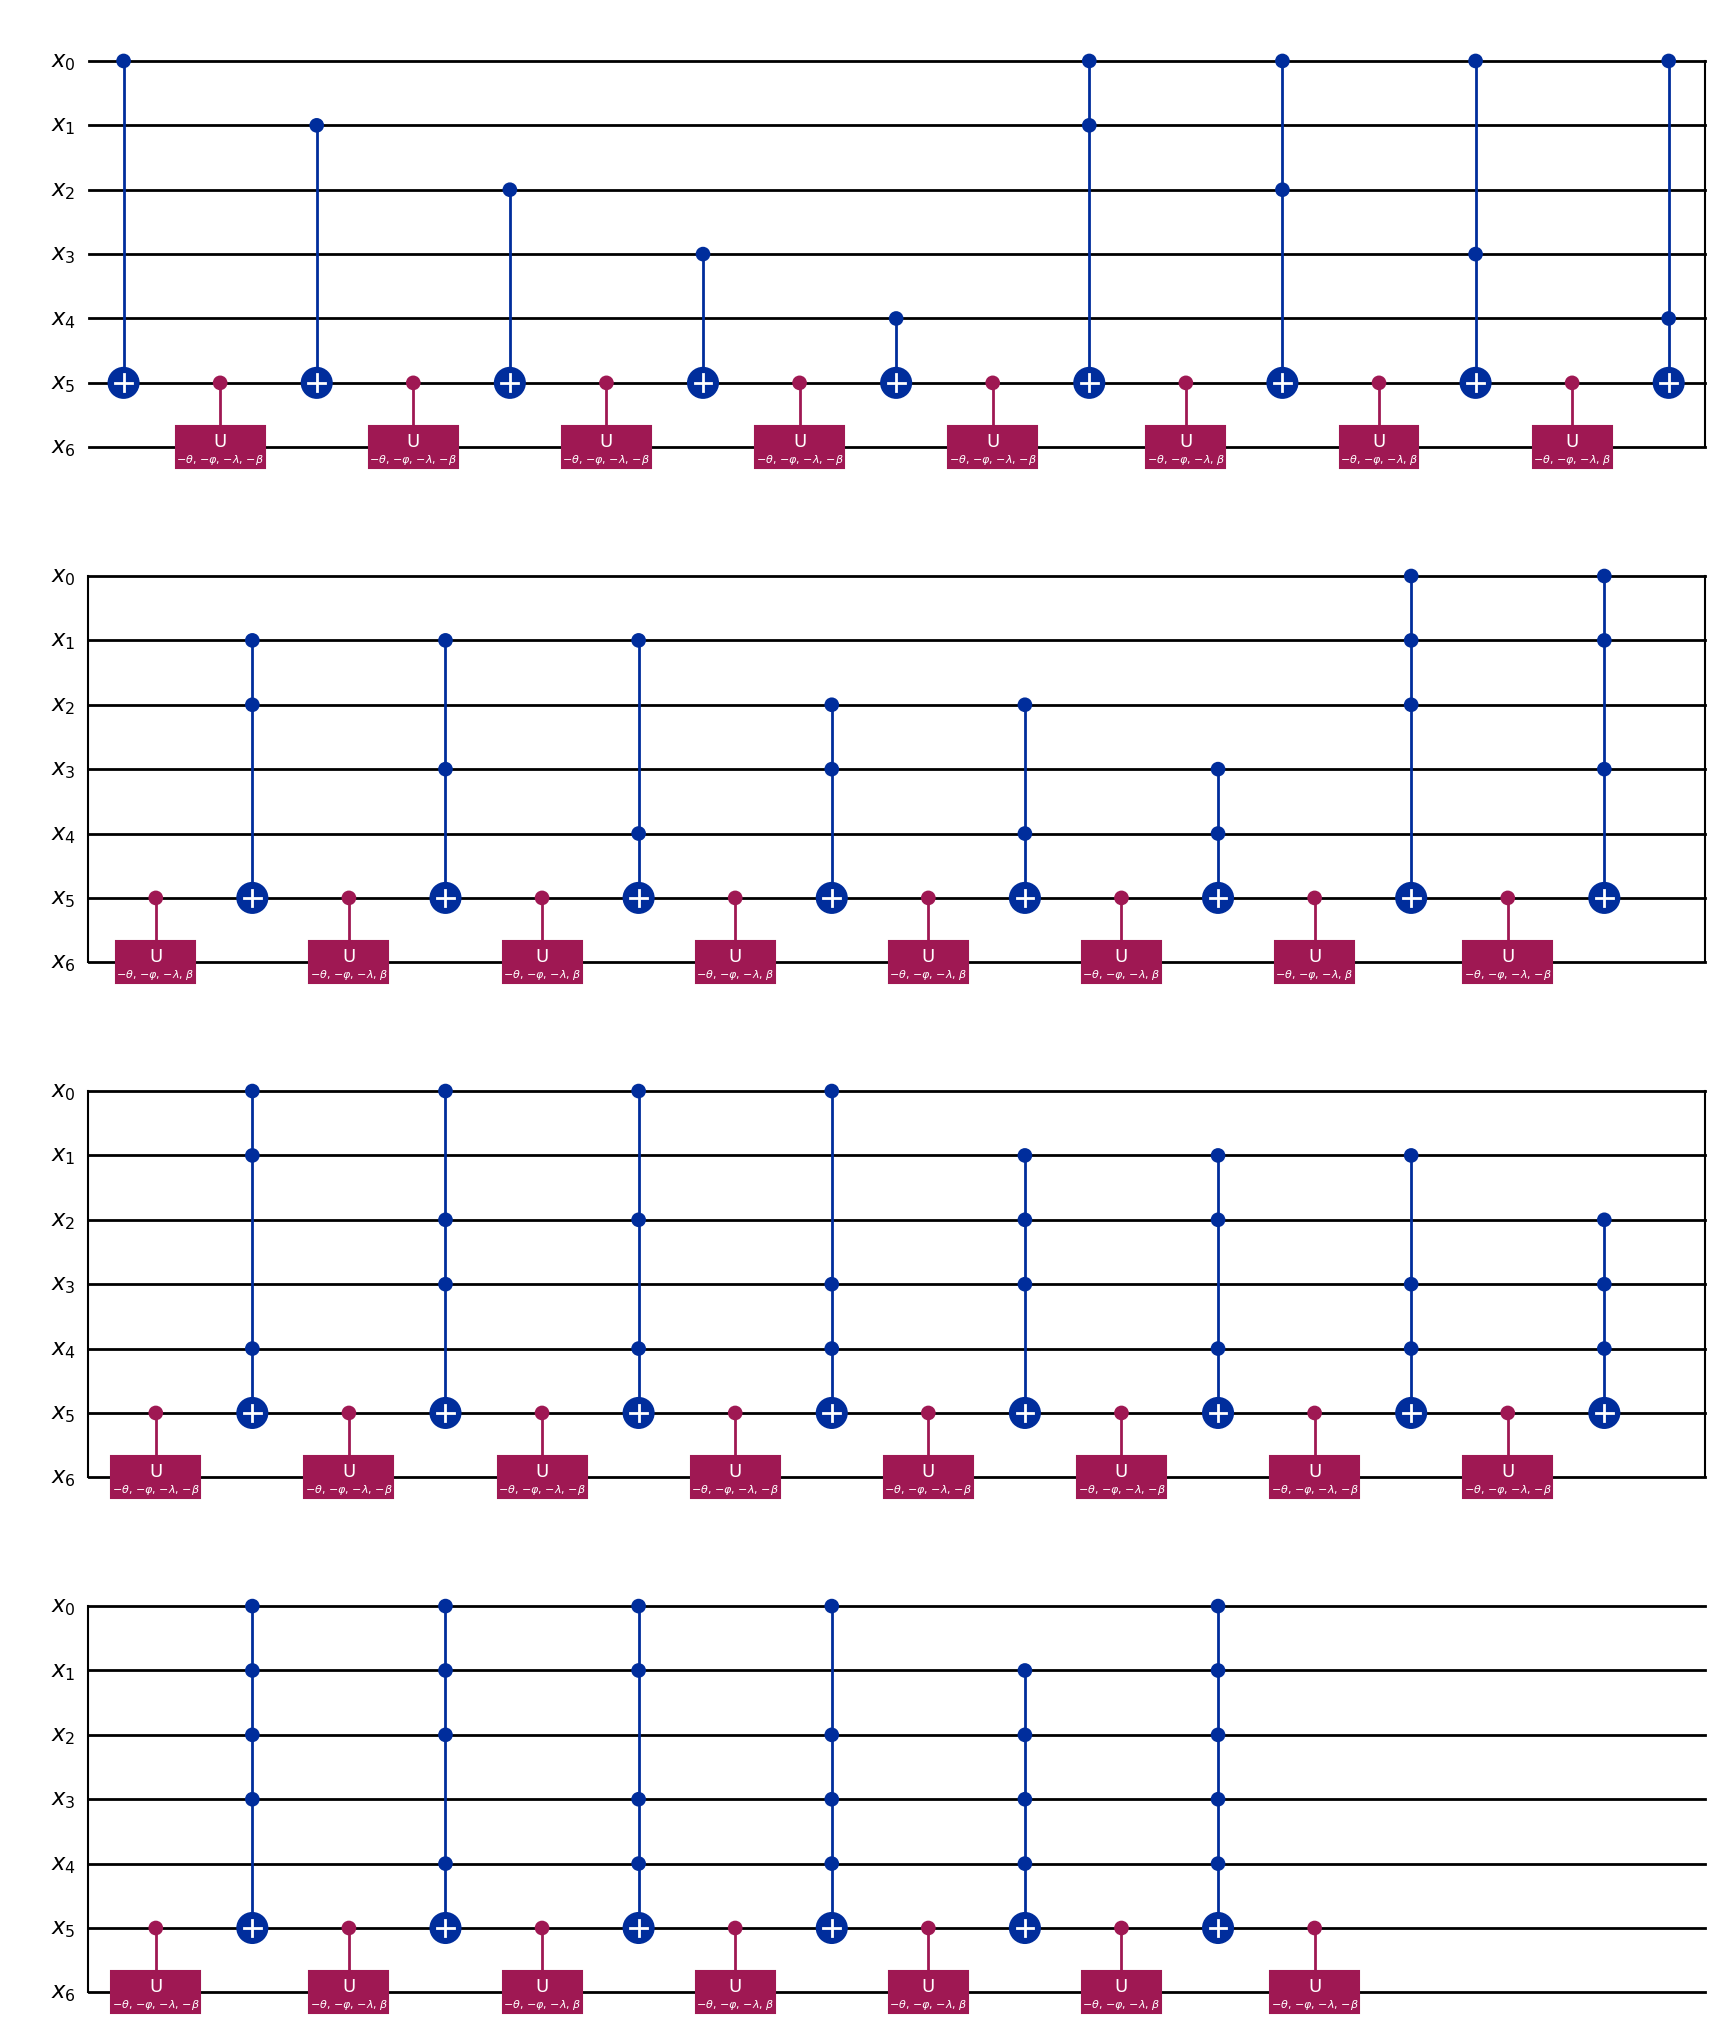

In [477]:
N = 5
Bar_qr = QuantumRegister(N+2,'x')
Bar_qc = QuantumCircuit(Bar_qr)
Bar_bits = list(range(0, N))

for m in range(1,N+1):#ranging over the degree of monomials
    shape = [N]*m
    for iK in itertools.product(*[range(s) for s in shape]):
        if Inc_K(iK, m): #Inc_K verifies condition   
            #print(list(iK))
            Bar_qc.mcx(list(iK),N)##Alternating with CV and CV^\dag depending on m%2. At the ends this gives V^{2^{m-1}x_1x_2...x_N} = U
            if (m%2==0):
                Bar_qc.cu(-Theta, -Phi, -Lambda, Beta, control_qubit=N, target_qubit=N+1)#not sure what beta is doing. compiler asked for xtra parameter
            else: 
                Bar_qc.cu(-Theta, -Phi, -Lambda, -Beta, control_qubit=N, target_qubit=N+1)#not sure what beta is doing. compiler asked for xtra parameter

Bar_qc.draw(output='mpl')

We now make some attempts to spot a patter for higher $C^nU$ using the $\textbf{transpile}$ method

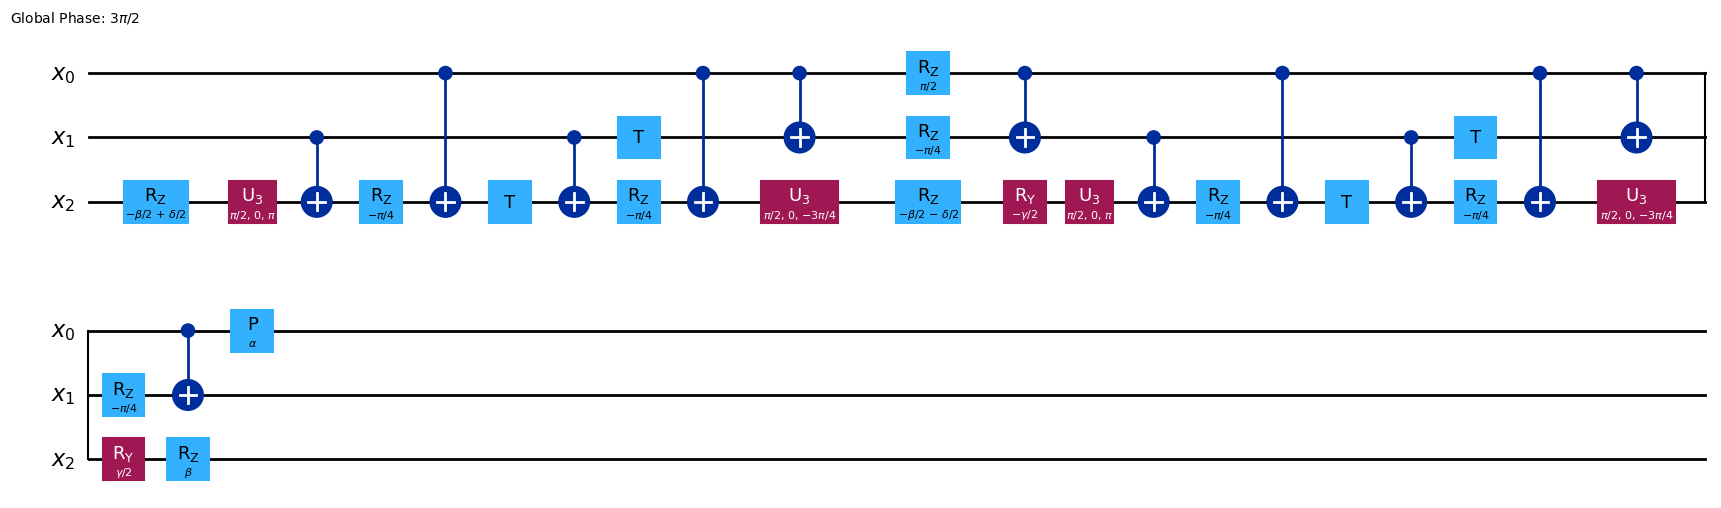

In [67]:
### Use of 'transpile' function to factor CCU using pre-fixex gates:
Decomp_CCU = transpile(CCU, basis_gates=['rz','ry','u3','t','p', 's','cx'])
Decomp_CCU.draw(output="mpl")

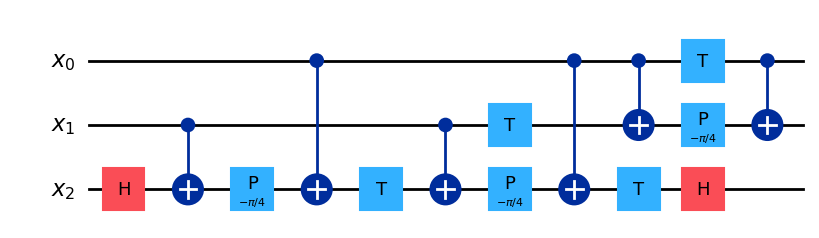

In [7]:
### Use of 'transpile' function to factor CCX using pre-fixex gates:

CCX_reg = QuantumRegister(size=3, name='x')
CCX = QuantumCircuit(CCX_reg, name = 'CCX')

CCX.ccx(0,1,2)

#Decomp_CCX = transpile(CCX, basis_gates=['u3', 'rz','ry','t', 'h','cx'])
Decomp_CCX = transpile(CCX, basis_gates=['p','t', 'h','cx'])
Decomp_CCX.draw(output="mpl")

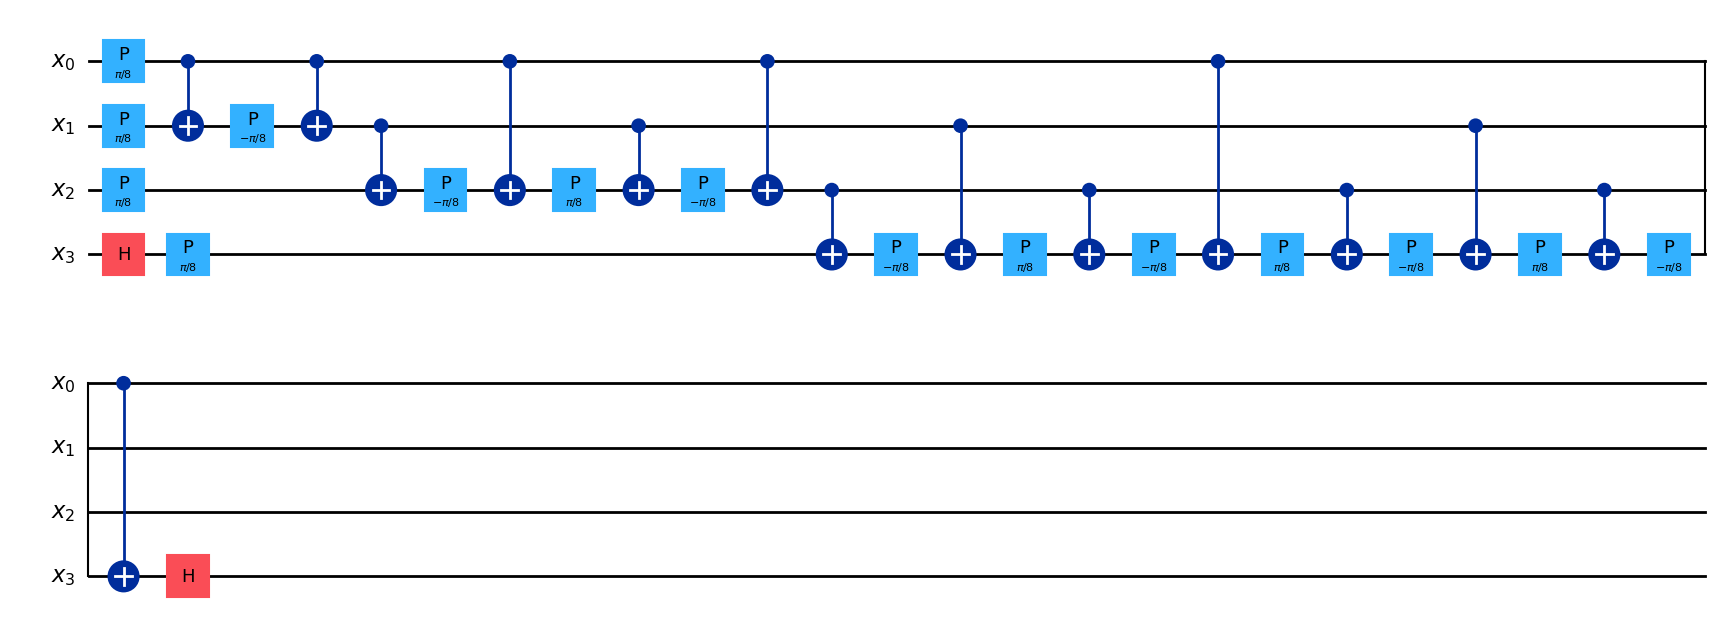

In [9]:
### Use of 'transpile' function to factor C^nX using pre-fixex gates:
n=4
CnX_reg = QuantumRegister(size=n, name='x')
CnX = QuantumCircuit(CnX_reg, name = 'CnX')
cbits = list(range(0, n-1))

CnX.mcx(cbits,n-1)
#CnX.draw(output='mpl')

Decomp_CnX = transpile(CnX, basis_gates=['p', 'h','cx', 'ccx'])
Decomp_CnX.draw(output="mpl")

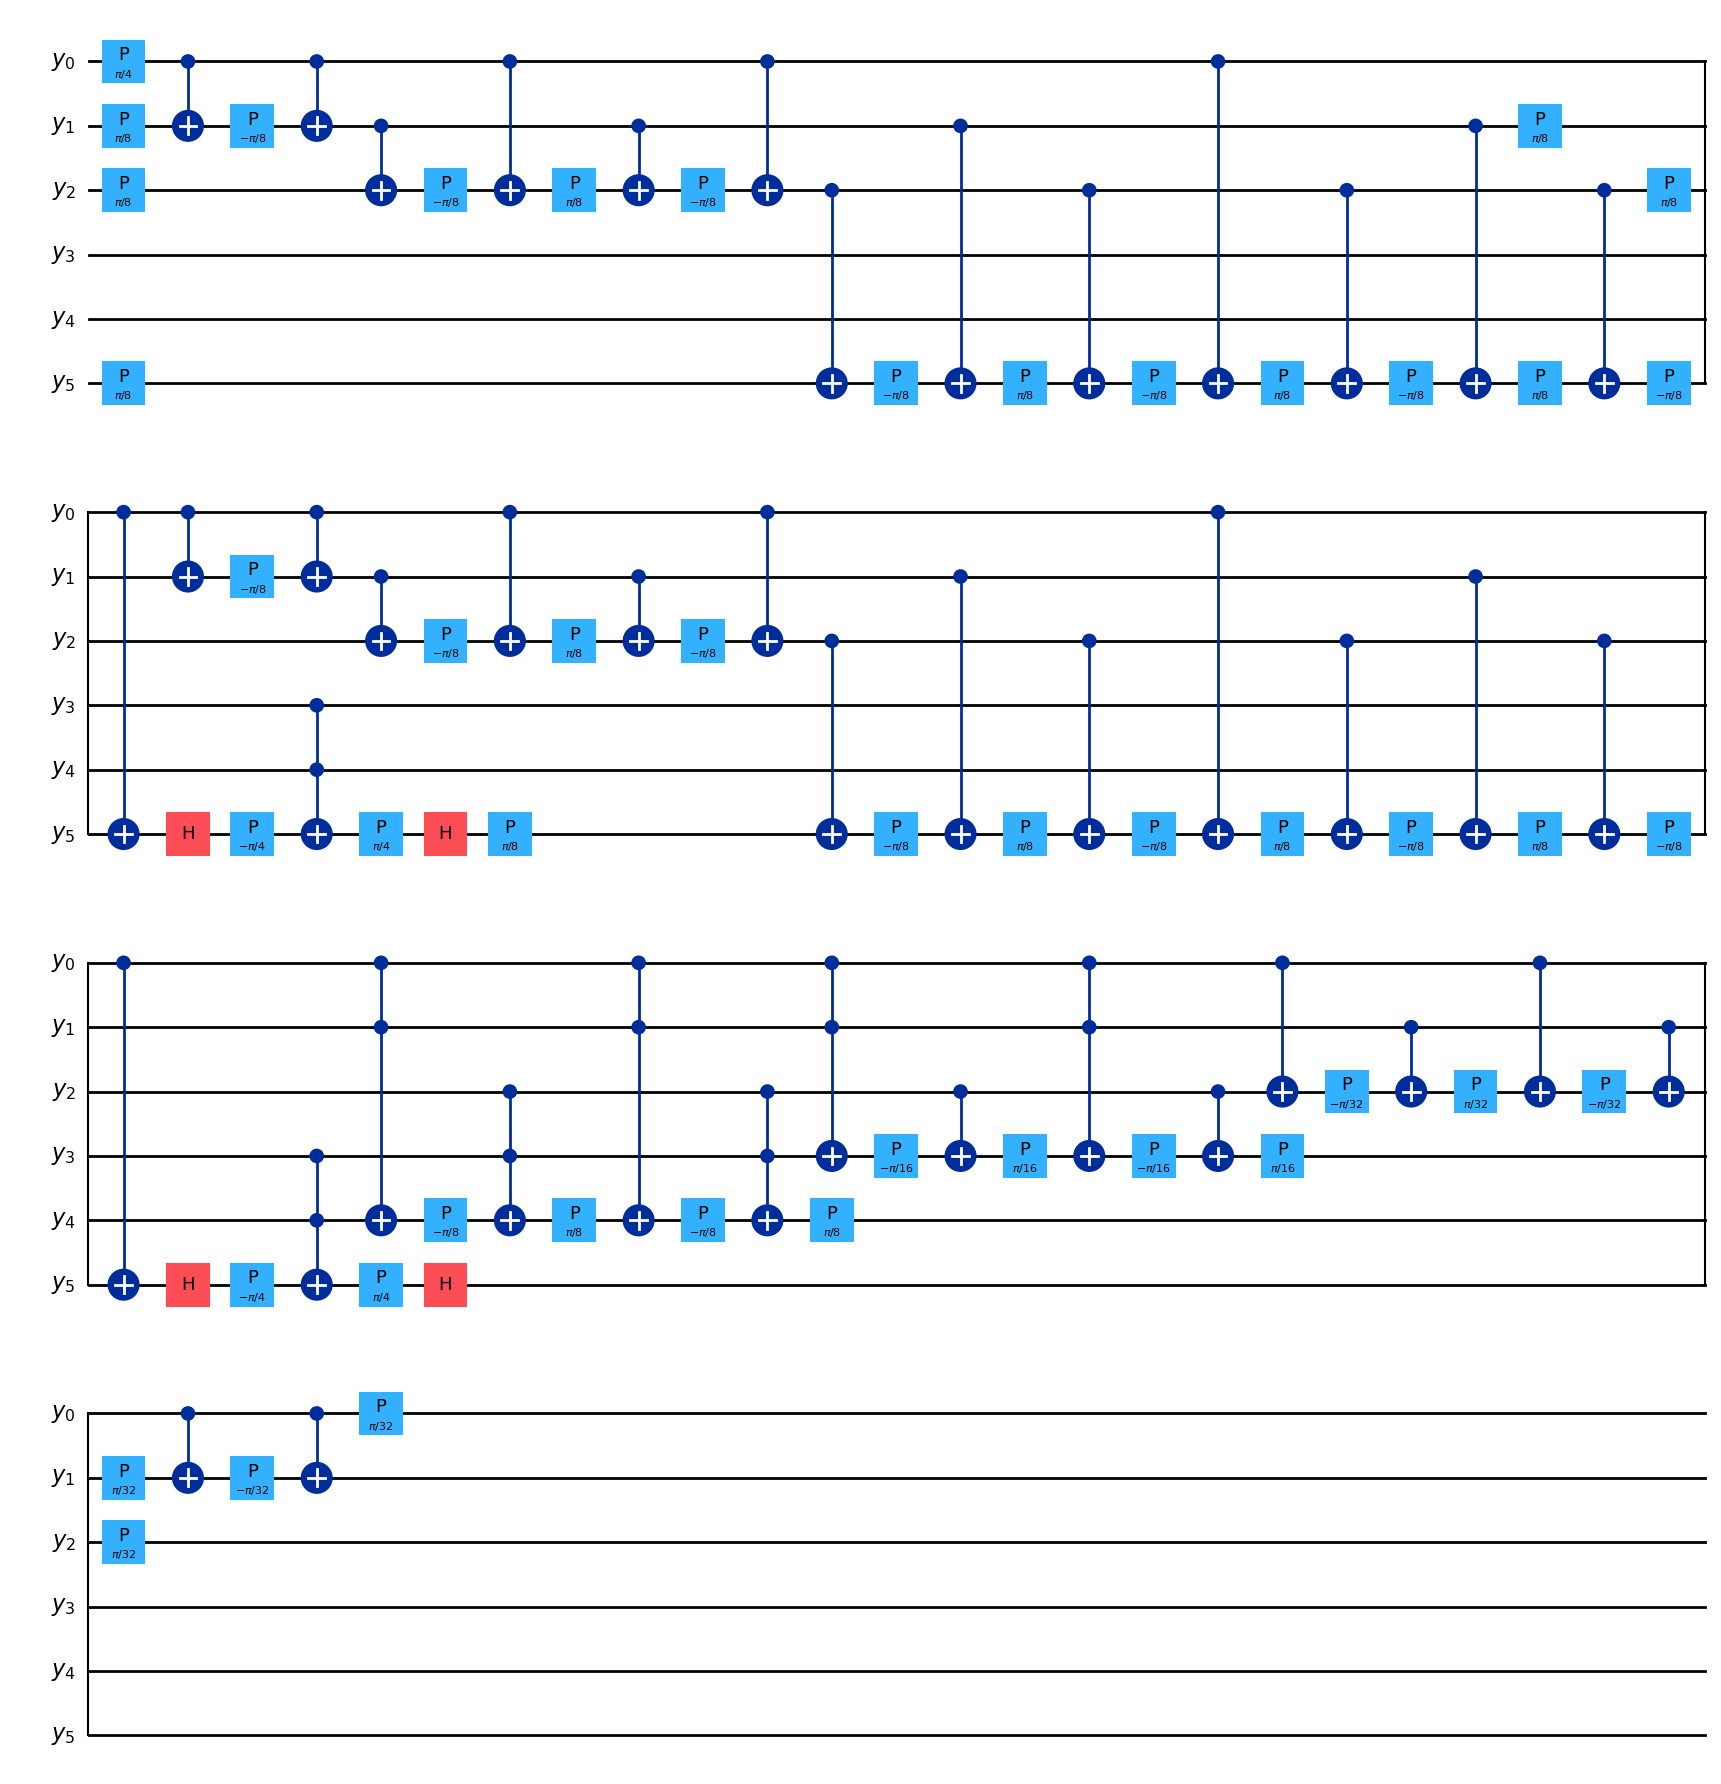

In [11]:
n = 6
qr = QuantumRegister(n,'y')
qc = QuantumCircuit(qr)
ybits = list(range(0, n-1))

qc.mcx(ybits, n-1)
qc.draw(output='mpl')

decomp_mcx = transpile(qc, basis_gates =['h', 'p', 'cx', 'ccx'])
decomp_mcx.draw(output='mpl')